In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
import xgboost

In [51]:
train = pd.read_csv("../../data/train.csv")
test = pd.read_csv("../../data/test.csv")
var_desc = pd.read_csv("../../data/variabledescription.csv")

In [56]:
## Functions to preprocess dataframes
    
## Function to fill missing values with given model
def predict_with_model(df, target, feats, model):
    cols_to_use = feats.copy()
    cols_to_use.append(target)
    temp = df[df[cols_to_use].notna().product(1).astype(bool)][cols_to_use]
    X = temp[feats]
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    y = temp[target]
    model.fit(X,y)
#     res = cross_val_score(SVR(C=5), X, y, cv=kf, scoring="r2")
#     return res.mean()
    to_pred_bool = (df[feats].notna().product(1) & df[target].isna())
    df.loc[to_pred_bool, target] = model.predict(scaler.transform(df.loc[to_pred_bool][feats])) 
    
    
####### FILLING FUNCTION ############
## Function to fill missing in categorical columns
def fill_missing_cat(df, *col_val_pairs):
    for pair in col_val_pairs:
        df[pair[0]].fillna(pair[1], inplace=True)

## Function to fill missing in numeric columns with fixed value 
def fill_missing_num_with_val(df, *col_val_pairs):
    for pair in col_val_pairs:
        df[pair[0]].fillna(pair[1], inplace=True)
        
        
## Function to fill missing with median
def fill_with_median(df, *cols):
    for col in cols:
        df[col].fillna(np.median(df[df[col].notna()][col]), inplace=True)

        
####### NEW FEATURE FUNCTIONS ############
## Function to create between feature
def add_days_between(df, begin, end, name):
    df[name] = (pd.to_datetime(df[end]) - pd.to_datetime(df[begin])).dt.days.fillna(0)

        
## function to process dataframes
def process_df(df):
    df = df.copy()
    ## filling missing categorical features
    fill_missing_cat(df,
                     ("NursDetFactor", "None"),
                     ("TransDetFactor", "None"),
                     ("TransplantingIrrigationPowerSource", "Manual"),
                     ("OrgFertilizers", "None"),
                     ("CropbasalFerts", "Unknown"),
                     ("TransplantingIrrigationSource", "Unknown"),
                     ("PCropSolidOrgFertAppMethod", "None_applied")
                    )
    ## filling missing numeric values with fixed number
    fill_missing_num_with_val(df,
                              ("StandingWater", 0),
                              ("CropOrgFYM", 0),
                              ("2appDaysUrea", 0)
                             )
    
    ## fill missing with model
    predict_with_model(df, "1tdUrea", ["Acre", "BasalDAP", "BasalUrea", "CultLand", "CropCultLand"], LinearRegression())
    predict_with_model(df, "2tdUrea", ["1tdUrea", "Acre", "BasalDAP"], SVR(C=20))
    predict_with_model(df, "BasalDAP", ["1tdUrea", "Acre"], SVR(C=15))
    predict_with_model(df, "BasalUrea", ["BasalDAP", "1tdUrea", "2tdUrea"], LinearRegression())
    
    ## filling some missing values with median
    fill_with_median(df, "SeedlingsPerPit", "TransplantingIrrigationHours", "TransIrriCost", "1tdUrea", "2tdUrea", "BasalDAP",
                    "1appDaysUrea", "BasalUrea")
    
    ## feature generation side
    ## adding days between feaures
    add_days_between(df, "RcNursEstDate", "SeedingSowingTransplanting", "NursToTransDays")
    
    
    ## dropping columns
    cols_to_drop = ["RcNursEstDate", "Ganaura", "2appDaysUrea"]
    df.drop(cols_to_drop, axis=1, inplace=True)
    
    
    return df

In [53]:
train_processed = process_df(train)
train_processed[["NursDetFactor", "TransDetFactor", "TransplantingIrrigationSource", "StandingWater","NursToTransDays"]]

,NursDetFactor,TransDetFactor,TransplantingIrrigationSource,StandingWater,NursToTransDays
0,CalendarDate IrrigWaterAvailability SeedAvaila...,CalendarDate SeedlingAge RainArrival IrrigWate...,Boring,2.0,24.0
1,CalendarDate PreMonsoonShowers IrrigWaterAvail...,CalendarDate SeedlingAge RainArrival IrrigWate...,Boring,3.0,30.0
2,PreMonsoonShowers IrrigWaterAvailability Labou...,SeedlingAge IrrigWaterAvailability LaborAvaila...,Boring,2.0,54.0
3,CalendarDate PreMonsoonShowers IrrigWaterAvail...,CalendarDate SeedlingAge RainArrival IrrigWate...,Unknown,0.0,30.0
4,CalendarDate IrrigWaterAvailability SeedAvaila...,SeedlingAge RainArrival IrrigWaterAvailability...,Boring,2.0,29.0
...,...,...,...,...,...
3865,None,None,Boring,5.0,17.0
3866,IrrigWaterAvailability LabourAvailability,IrrigWaterAvailability LaborAvailability,Boring,3.0,22.0
3867,CalendarDate IrrigWaterAvailability,CalendarDate IrrigWaterAvailability,Boring,5.0,23.0
3868,SeedAvailability IrrigWaterAvailability,IrrigWaterAvailability RainArrival SeedlingAge,Canal,9.0,26.0


In [54]:
train_processed.isna().sum()

ID                                       0
District                                 0
Block                                    0
CultLand                                 0
CropCultLand                             0
LandPreparationMethod                    0
CropTillageDate                          0
CropTillageDepth                         0
CropEstMethod                            0
SeedingSowingTransplanting               0
SeedlingsPerPit                          0
NursDetFactor                            0
TransDetFactor                           0
TransplantingIrrigationHours             0
TransplantingIrrigationSource            0
TransplantingIrrigationPowerSource       0
TransIrriCost                            0
StandingWater                            0
OrgFertilizers                           0
CropOrgFYM                               0
PCropSolidOrgFertAppMethod            1337
NoFertilizerAppln                        0
CropbasalFerts                           0
BasalDAP   

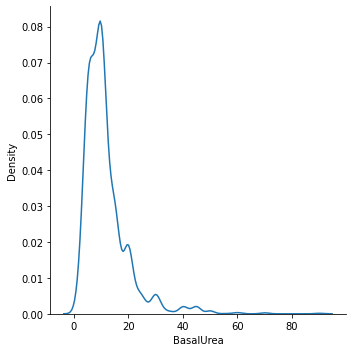

In [50]:
sns.displot(train_processed["BasalUrea"], kind="kde")

In [42]:
rs = 132
kf = KFold(n_splits = 5, shuffle=True, random_state=rs)

In [43]:
## training model for `TransIrriCost`
temp_target = "BasalUrea"
cols_to_use = ["BasalDAP", "1tdUrea", "2tdUrea", temp_target]
temp = [train[cols_to_use].notna().product(1).astype(bool)][cols_to_use]
temp_X = temp[cols_to_use[:-1]]
## standard scaling
temp_X = StandardScaler().fit_transform(temp_X)
temp_y = temp[temp_target]

In [44]:
res = cross_val_score(LinearRegression(), temp_X, temp_y, cv=kf, scoring="r2")
res.mean()

0.9342932696026536

In [ ]:
temp_params = {
    "n_estimators": [100, 500, 1000],
    "learning_rate": [0.01, 0.005, 0.001],
    "max_depth": [2,4,6,8]
}
temp_grid = GridSearchCV(xgboost.XGBRegressor(), temp_params, cv = kf, scoring="r2")
temp_grid.fit(temp_X, temp_y)

In [340]:
print(temp_grid.best_score_)
print(temp_grid.best_params_)

0.9291422485980704
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 500}


In [477]:
# predict_with_model(train, "1tdUrea", ["Acre", "BasalDAP", "BasalUrea", "CultLand", "CropCultLand"], LinearRegression())

In [478]:
train["1tdUrea"].isna().sum()

224

In [559]:
(train[["1tdUrea", "Acre"]].notna().product(1) & train["BasalDAP"].isna()).sum()

400

In [41]:
train[["BasalUrea", "BasalDAP", "1tdUrea"]].notna().product(1).sum()

2166